# Catmull-Rom Analysis
This Notebook contains all the analysis made directly on the Catmull-Rom CSV file.

## Libraries

In [69]:
library(plyr)

library(tidyverse)
library(DT) # dependency
library(ggthemes) # dependency

## Universal functions and variables

In [70]:
scenarios <- c("temperature", "rain", "sales", "gym_memberships", "wage", "facebook_friends")

readable_scenarios <- c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends")

subconditions = c(1, 2, 3)

condition_names = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative")

In [71]:
get_range <- function(condition){
    
    range_array <- switch(
            condition,
            temperature = c(-10, 40),
            sales = c(0, 5000),
            facebook_friends = c(0, 1000),
            rain = c(0, 100),
            gym_memberships = c(0, 50),
            wage = c(0, 50)
        )
    
    range_value <- range_array[2] - range_array[1]
    
    delta <- range_value / 10
    
    c(range_array[1] - delta, range_array[2] + delta)
}

In [72]:
to_pdf = TRUE

resolution = 100

## Preparing the data

In [73]:
data <- suppressWarnings(read_csv("catmull-rom-dataset.csv"));

Parsed with column specification:
cols(
  .default = col_double(),
  userId = col_character(),
  age = col_character(),
  datetime = col_character(),
  gender = col_character(),
  datetime_1 = col_character(),
  stage = col_integer(),
  scenario = col_character(),
  subcondition = col_integer(),
  pageIndex = col_integer(),
  noiseIndex = col_integer(),
  day0 = col_character(),
  day1 = col_character(),
  day2 = col_character(),
  day3 = col_character(),
  day4 = col_character(),
  day5 = col_character(),
  day6 = col_character(),
  day7 = col_character(),
  day8 = col_character(),
  day9 = col_character()
  # ... with 69 more columns
)
See spec(...) for full column specifications.


In [74]:
# To tidy data
tidy_data <- data %>% 
    gather(day, value, starts_with("day"))

# Transform strings to numbers
tidy_data <- tidy_data %>%
    mutate(day = as.numeric(gsub("day", "", day)),
           value = as.numeric(value))

# Changes values to make them readable
# TODO: make this tidier:
tidy_data$subcondition_name <- mapvalues(tidy_data$subcondition,
                                  from = subconditions,
                                  to   = condition_names[2:4])

tidy_data$condition_name <- ifelse(tidy_data$stage==1,
                                   condition_names[1], 
                                   "")

tidy_data$condition_name <- ifelse(tidy_data$stage == 2, 
                                   tidy_data$subcondition_name, 
                                   tidy_data$condition_name)

Warning message in eval(substitute(expr), envir, enclos):
"NAs introduced by coercion"

# Plots

Preparing the data

In [75]:
dat <- data.frame(
                    id        = tidy_data$userId,
                    day       = tidy_data$day, #x
                    value     = tidy_data$value, #y
                    condition = tidy_data$condition_name,
                    scenario  = tidy_data$scenario
                 )

# Change the readable names of the variables
dat$scenario <- mapvalues( dat$scenario, 
                           from = scenarios,
                           to = readable_scenarios)


# Order on the plot
dat$condition <- factor( dat$condition, 
                         levels = condition_names)

dat$scenario <- factor( dat$scenario, 
                        levels = readable_scenarios)

## Specific data for the plots

In [76]:
# Subset the data to be shown
dat <- subset(dat, day > 30 & day < 365*4-30)

dplot <- subset(dat, day %in% seq(min(dat$day), max(dat$day), resolution))

### Mean plot

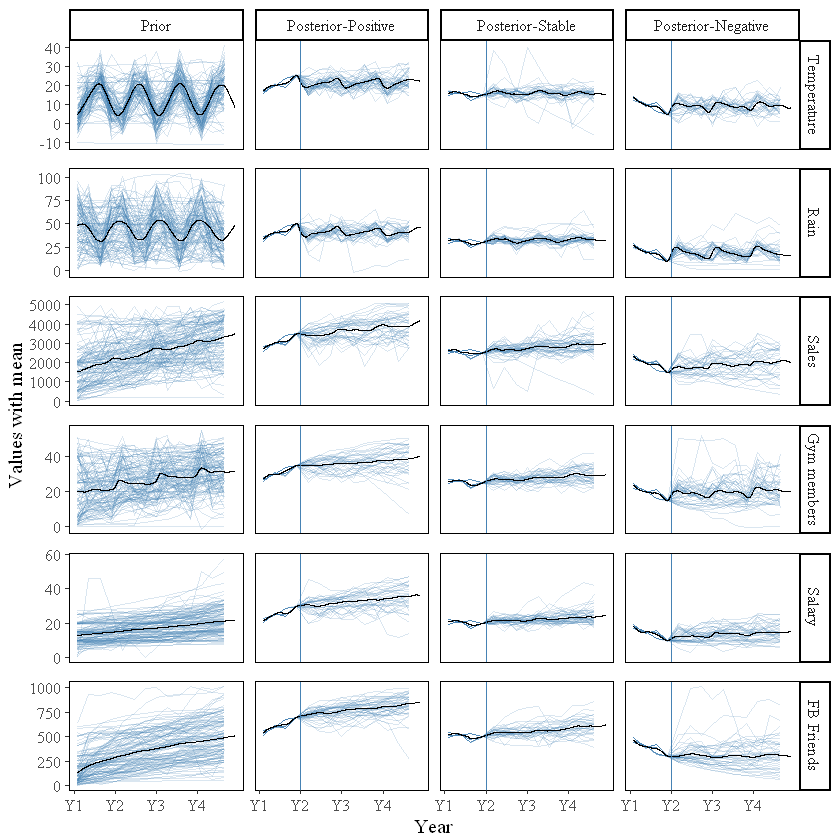

In [77]:
#Calculate the trend
trend <- dat %>%
    ddply(~scenario+condition+day, summarize, value=mean(value, trim=0.1))

trend$id <- "1"

p1 <- dplot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Values with mean") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


p1

### Variance

In [78]:
trend <- dat %>%
    ddply(~scenario+condition+day, summarize, value=var(value))

trend$id <- "1"

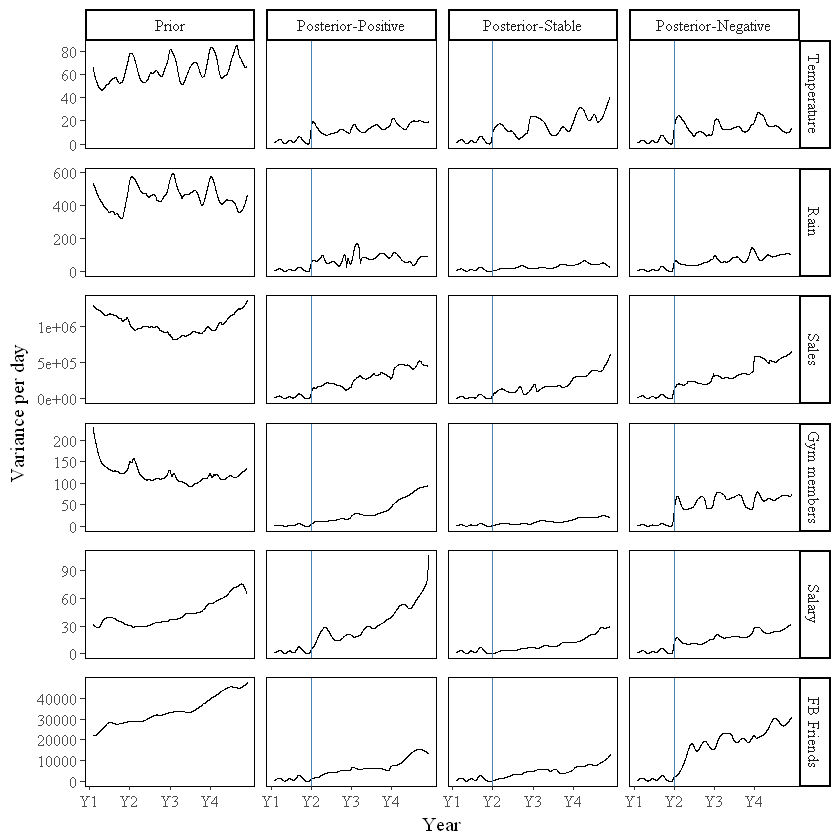

In [79]:
p2 <- dplot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        #geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Variance per day") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))

p2

### Derivative (slope)

In [80]:
slope <- function( column ) {
    
    y1 = column$value[-1]
    
    y0 = column$value[-length(column$value)]
    
    return(y1-y0)
}

In [81]:
slopes <- ddply(dat, ~condition+scenario+id, slope)

slopes <- slopes %>% 
    gather(day, value, starts_with("V")) %>%
    mutate(day = as.numeric(gsub("V", "", day)))

# Order on the plot
slopes$condition <- factor( slopes$condition, 
                         levels = condition_names)

slopes$scenario <- factor( slopes$scenario, 
                        levels = readable_scenarios)

In [82]:
trend <- slopes %>%
    ddply(~scenario+condition+day, summarize, value=mean(value))

trend$id <- "1"

slopes_plot <- subset(slopes, day %in% seq(min(dat$day), max(dat$day), resolution))

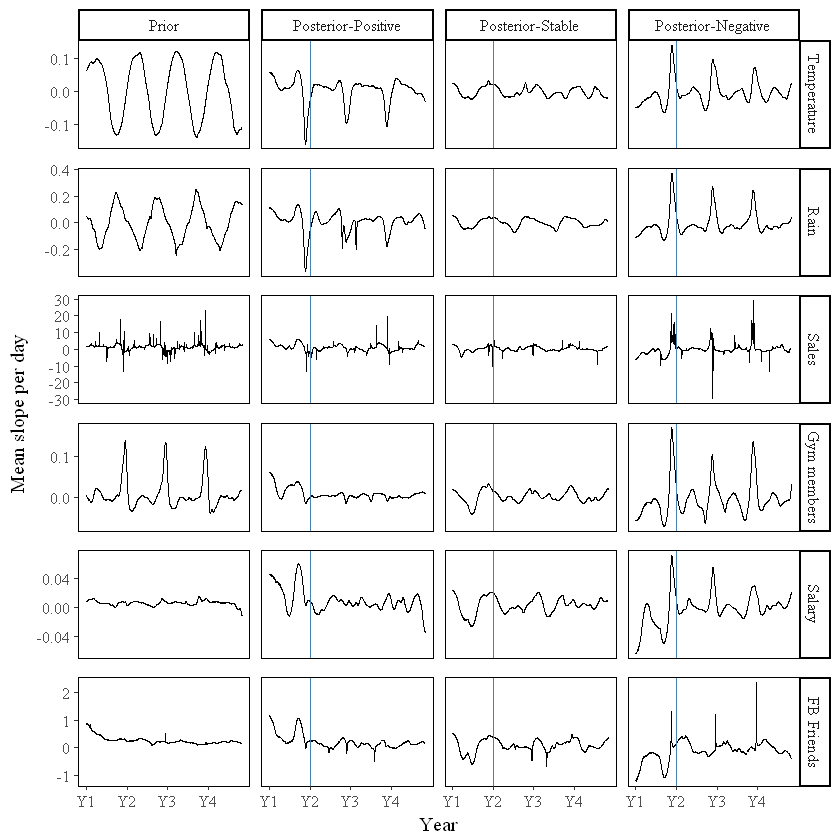

In [83]:
p3 <- slopes_plot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        #geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Mean slope per day") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))

p3

In [84]:
pdf("compforecasts3.pdf")
p1
p2
p3
dev.off()

png 
  2